In [1]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from dateutil.relativedelta import relativedelta
import seaborn as sns
from wishpy.dataworker import DataWorker
dw = DataWorker(google_secret='../../../wishpy/client_secret.json')
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/wishpy/dataworker.py:83: UserWarning: [Errno 2] No such file or directory: '../../../wishpy/client_secret.json'
  warnings.warn(str(e))


In [2]:
df = dw.td_query('''
SELECT delivery_program,
       shipping_country,
       td_time_format(ts_released_from_t,'yyyy-MM-dd','America/Los_Angeles') as release_date,
       ts_wp_order_creation_from_t,
       ts_fm_wp_order_creation_from_w,
       ts_tracking_created_from_t,
       ts_fm_track_created_from_w,
       ts_marked_shipped_from_t,
       ts_confirmed_shipped_from_t,
       ts_fm_carrier_pickup_from_w,
       ts_fm_arrive_first_mile_from_w,
       ts_fm_arrive_epc_warehouse_from_w,
       ts_lm_combine_complete_from_w,
       ts_lm_track_created_from_w,
       ts_lm_depart_epc_warehouse_from_w,
       
       round((ts_tracking_created_from_t - ts_fm_track_created_from_w)/3600.00 , 2) as delta_tracking_created_hr,
       
       round((ts_fm_arrive_epc_warehouse_from_w - ts_released_from_t)/3600.00 , 2)as fm_ttd_hr,
       round((ts_fm_track_created_from_w - ts_released_from_t)/3600.00 , 2)as fm_release_track_ttd_hr,
       round((ts_fm_carrier_pickup_from_w - ts_fm_track_created_from_w)/3600.00 , 2)as fm_track_pickup_ttd_hr,
       round((ts_fm_arrive_epc_warehouse_from_w - ts_fm_carrier_pickup_from_w)/3600.00 , 2)as fm_pickup_warehouse_ttd_hr,
       
       round((ts_lm_depart_epc_warehouse_from_w - ts_fm_arrive_epc_warehouse_from_w)/3600.00 , 2) as warehouse_ttd_hr,
       round((ts_lm_track_created_from_w - ts_fm_arrive_epc_warehouse_from_w)/3600.00 , 2) as warehouse_track_ttd_hr,
       round((ts_lm_combine_complete_from_w - ts_lm_track_created_from_w)/3600.00 , 2) as warehouse_track_combine_ttd_hr,
       round((ts_lm_depart_epc_warehouse_from_w - ts_lm_track_created_from_w)/3600.00 , 2) as warehouse_combine_depart_ttd_hr
       
from analytics.fm_warehouse_base1
'''
                ,job_id=688354315)

You can look at job id 688354315


In [3]:
df.tail(5)
#pd.to_datetime(1578043897,unit='s')

delivery_program shipping_country release_date  \
4586954              EPC               US   2020-01-08   
4586955              EPC               US   2020-01-08   
4586956              EPC               US   2020-01-08   
4586957              EPC               US   2020-01-08   
4586958              EPC               US   2020-01-08   

         ts_wp_order_creation_from_t  ts_fm_wp_order_creation_from_w  \
4586954                 1.578469e+09                      1578497490   
4586955                 1.578472e+09                      1578501104   
4586956                 1.578481e+09                      1578509736   
4586957                 1.578461e+09                      1578489467   
4586958                 1.578460e+09                      1578489031   

         ts_tracking_created_from_t  ts_fm_track_created_from_w  \
4586954                1.578538e+09                  1578497490   
4586955                1.578505e+09                  1578501104   
4586956                1.578535e+09                  1578509737   
4586957                1.578514e+09                  1578489467   
4586958                1.578525e+09                  1578489031   

         ts_marked_shipped_from_t  ts_confirmed_shipped_from_t  \
4586954              1.578538e+09                 1.578592e+09   
4586955              1.578505e+09                 1.578585e+09   
4586956              1.578535e+09                 1.578603e+09   
4586957              1.578514e+09                 1.578603e+09   
4586958              1.578525e+09                 1.578577e+09   

         ts_fm_carrier_pickup_from_w  ...  ts_lm_depart_epc_warehouse_from_w  \
4586954                 1.578584e+09  ...                       1.578912e+09   
4586955                 1.578577e+09  ...                       1.578912e+09   
4586956                 1.578595e+09  ...                       1.578911e+09   
4586957                 1.578594e+09  ...                       1.578911e+09   
4586958                 1.578571e+09  ...                       1.578911e+09   

         delta_tracking_created_hr  fm_ttd_hr  fm_release_track_ttd_hr  \
4586954                      11.29      76.65                     5.07   
4586955                       0.95     100.37                     5.71   
4586956                       6.97      72.21                     6.13   
4586957                       6.68      73.57                     0.50   
4586958                       9.96      98.14                     0.37   

         fm_track_pickup_ttd_hr  fm_pickup_warehouse_ttd_hr  warehouse_ttd_hr  \
4586954                   24.17                       47.41             43.69   
4586955                   21.17                       73.49             19.60   
4586956                   23.62                       42.45             45.40   
4586957                   29.08                       43.99             44.04   
4586958                   22.72                       75.05             19.47   

         warehouse_track_ttd_hr  warehouse_track_combine_ttd_hr  \
4586954                   26.69                           16.45   
4586955                    2.60                           16.45   
4586956                   28.78                           15.06   
4586957                   27.42                           15.06   
4586958                    2.84                           15.06   

         warehouse_combine_depart_ttd_hr  
4586954                            17.00  
4586955                            17.00  
4586956                            16.63  
4586957                            16.63  
4586958                            16.63  

[5 rows x 24 columns]

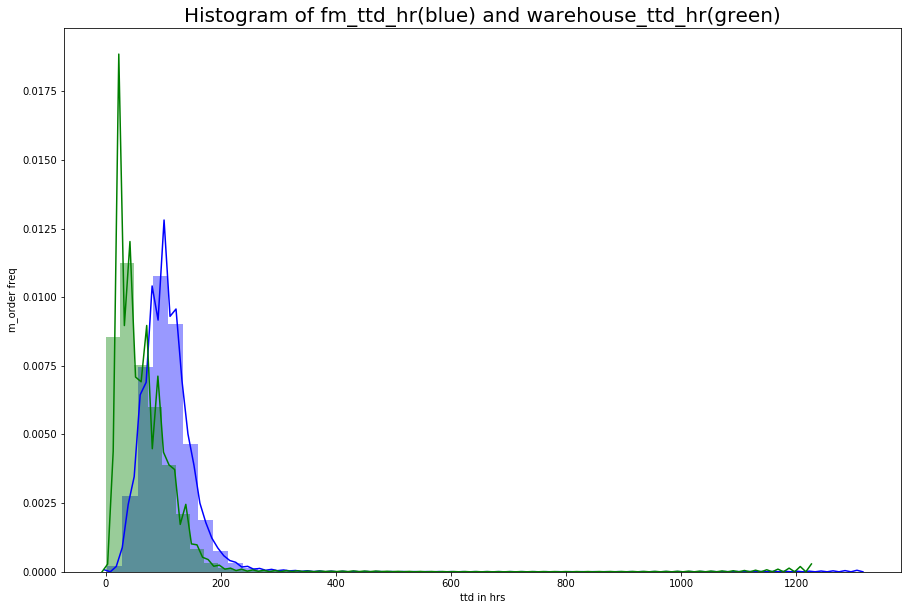

In [4]:
# seaborn histogram
plt.figure(figsize=(15,10))
sns.distplot(df.loc[pd.notnull(df.fm_ttd_hr),'fm_ttd_hr'], 
             hist=True, kde=True, 
             bins=50, color = 'blue')
sns.distplot(df.loc[pd.notnull(df.warehouse_ttd_hr),'warehouse_ttd_hr'], 
             hist=True, kde=True, 
             bins=50, color = 'green')
# adding labels and title
plt.title('Histogram of fm_ttd_hr(blue) and warehouse_ttd_hr(green)',size = 20)
plt.xlabel('ttd in hrs')
plt.ylabel('m_order freq')
plt.show()

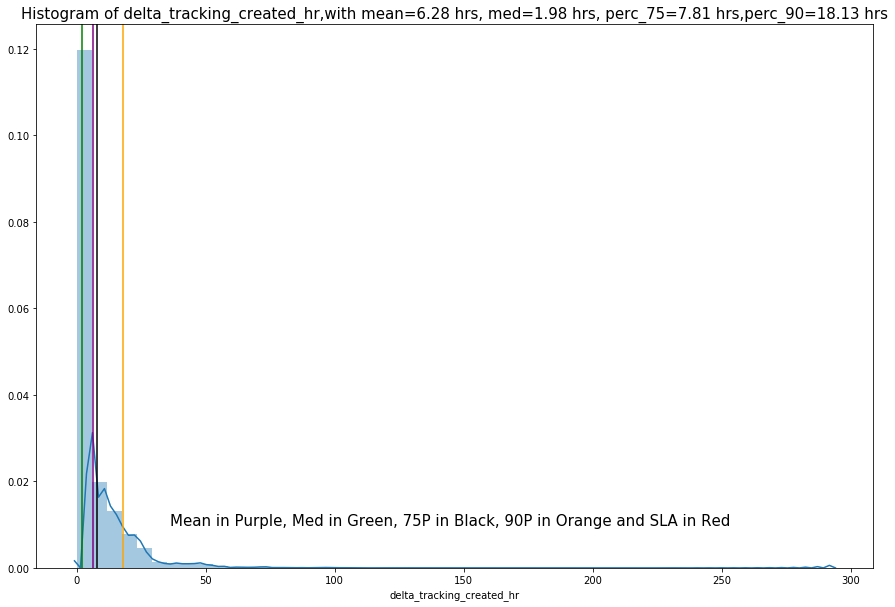

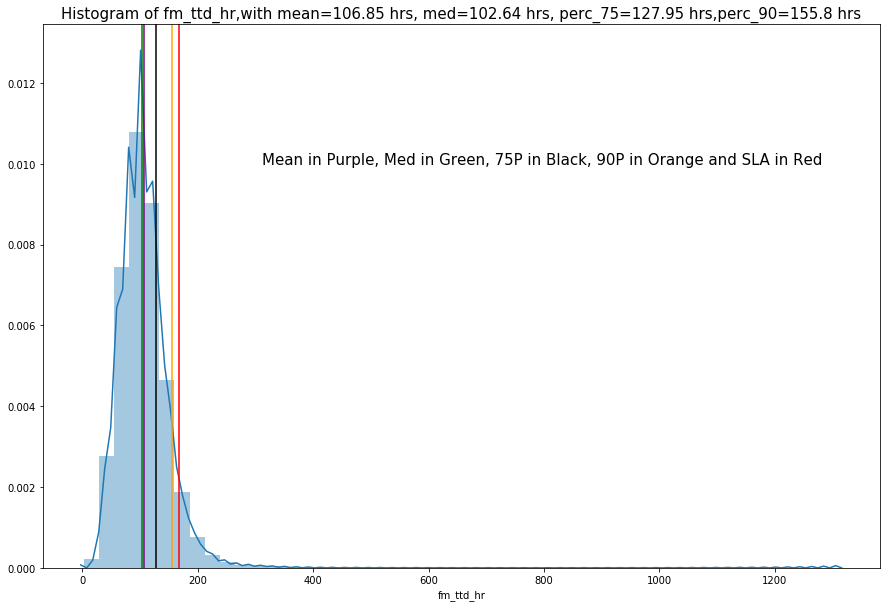

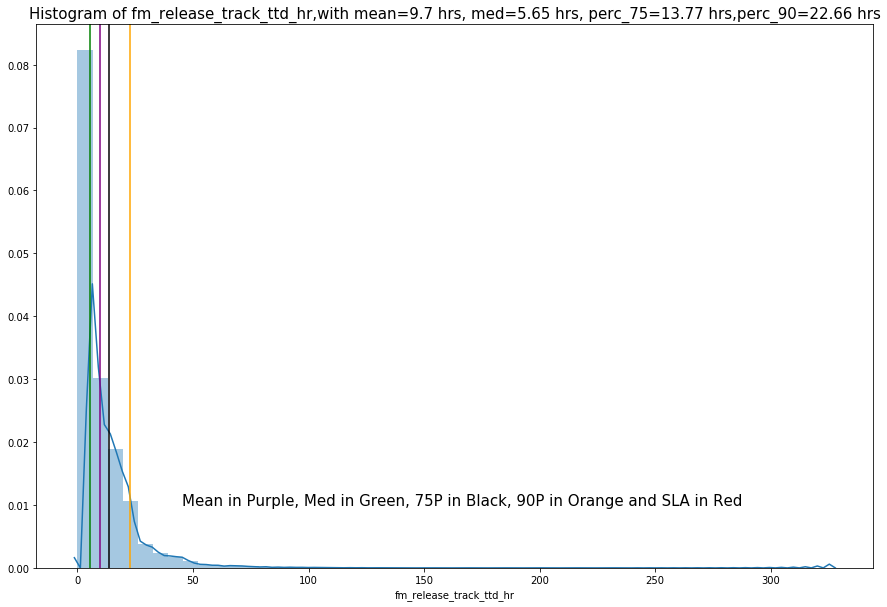

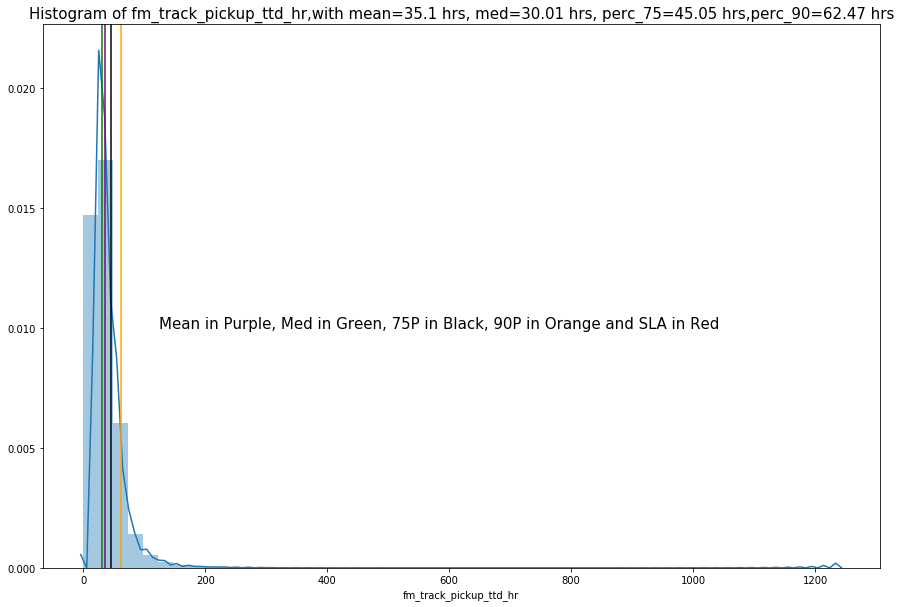

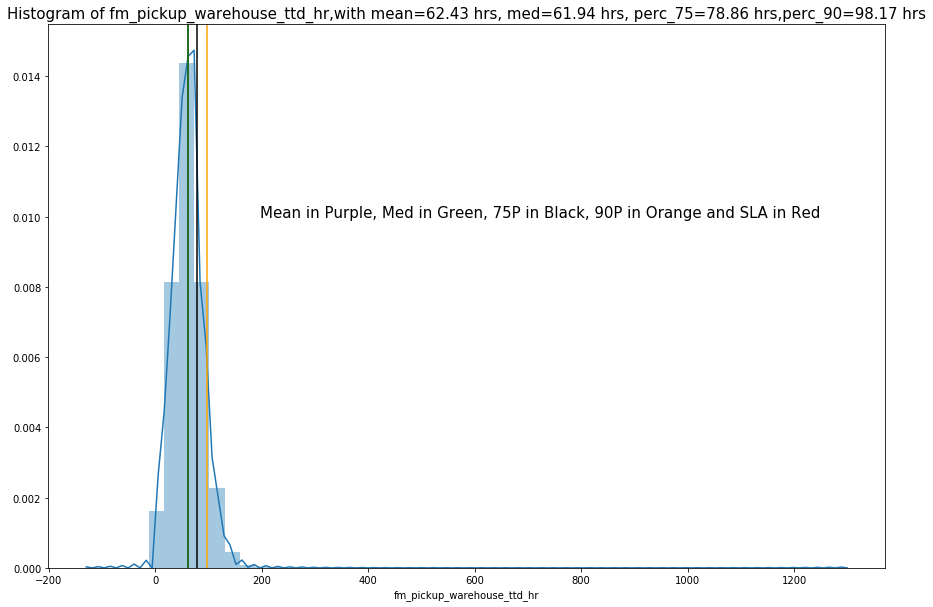

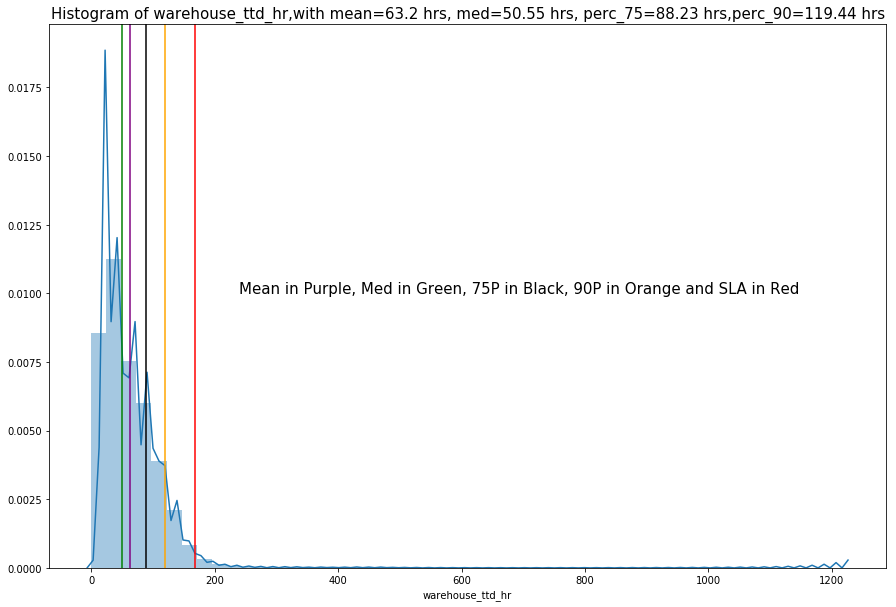

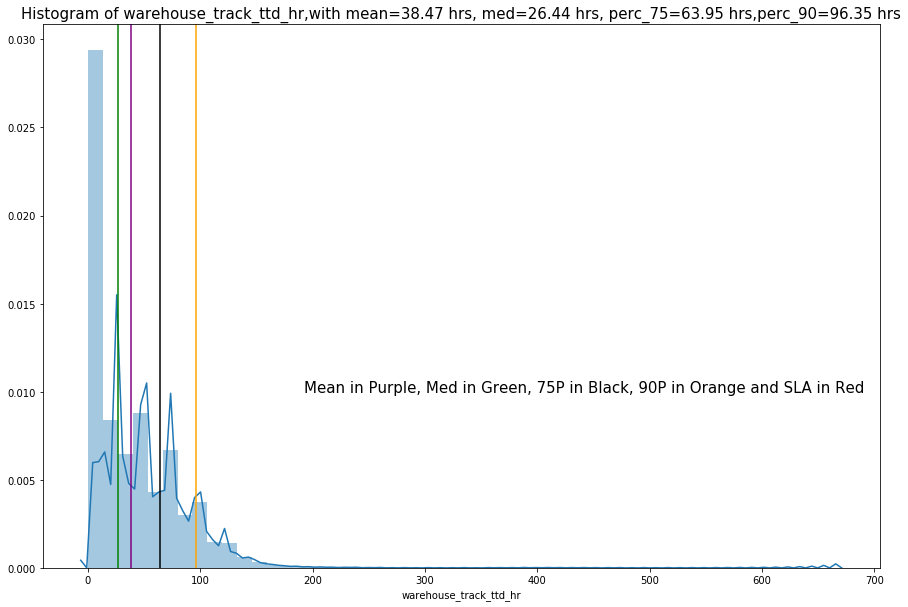

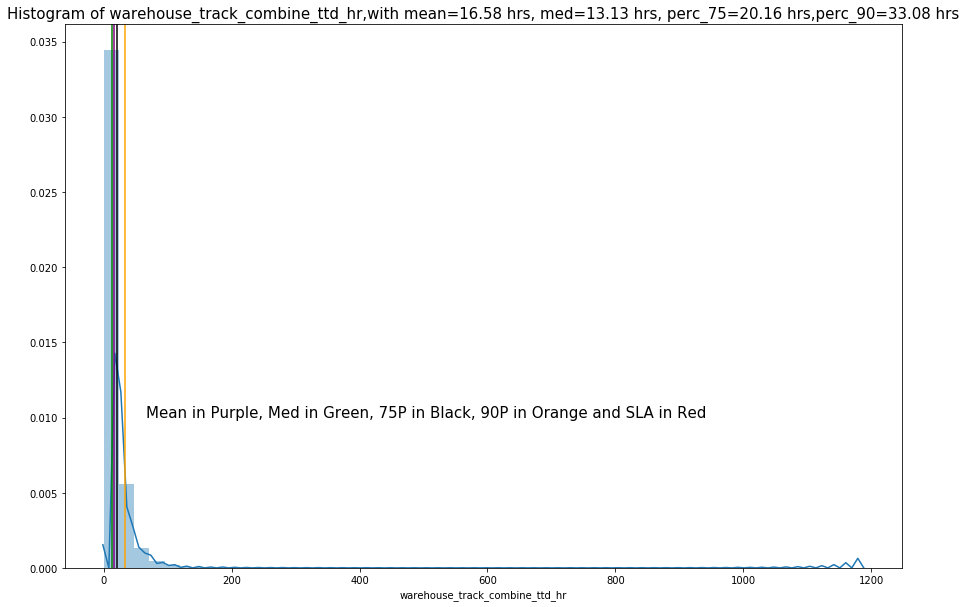

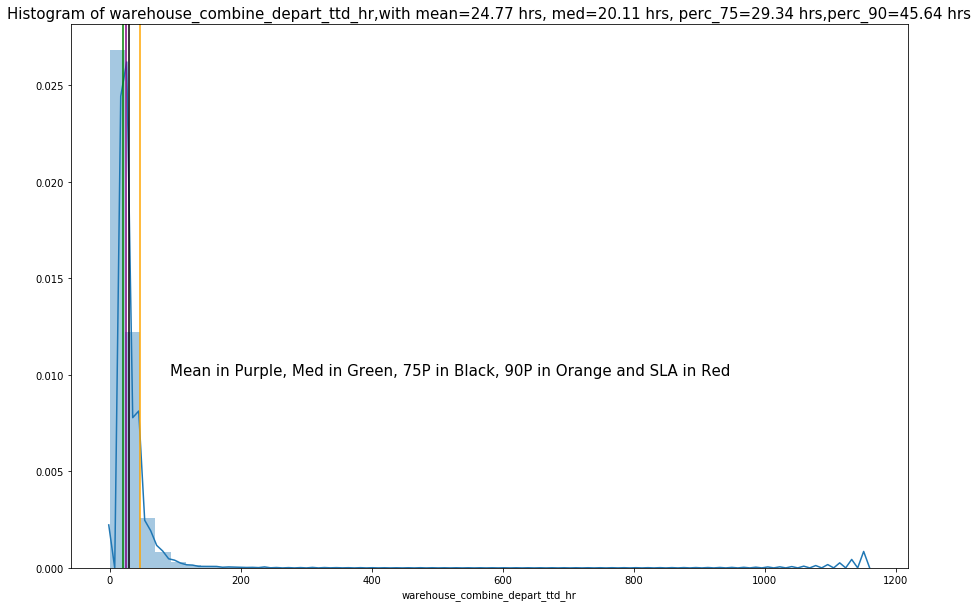

In [6]:
checkpoint_list = ['delta_tracking_created_hr','fm_ttd_hr','fm_release_track_ttd_hr','fm_track_pickup_ttd_hr','fm_pickup_warehouse_ttd_hr',
             'warehouse_ttd_hr','warehouse_track_ttd_hr','warehouse_track_combine_ttd_hr','warehouse_combine_depart_ttd_hr']

for cp in checkpoint_list:
    avg = round(df.loc[df[cp].notnull(),cp].mean(),2)
    perc_50 = round(df.loc[df[cp].notnull(),cp].median(),2)
    perc_75= round(df.loc[df[cp].notnull(),cp].quantile(0.75),2)
    perc_90= round(df.loc[df[cp].notnull(),cp].quantile(0.9),2)
    
    plt.figure(figsize=(15,10))
#    sns.set(rc={'figure.figsize':(12,10)})
    sns.distplot(df.loc[df[cp].notnull(),cp], hist=True, kde=True, bins=50)
    
    plt.title('Histogram of %s,with mean=%s hrs, med=%s hrs, perc_75=%s hrs,perc_90=%s hrs' %(cp,avg,perc_50,perc_75,perc_90), size = 15)
    plt.axvline(avg, 0, 1, color='purple')
    plt.axvline(perc_50, 0, 1, color='green')
    plt.axvline(perc_75, 0, 1,color='black')
    plt.axvline(perc_90, 0, 1, color='orange')
    if cp in ['fm_ttd_hr','warehouse_ttd_hr']:
        plt.axvline(7*24, 0, 1, color='red')
    plt.text(perc_90*2,0.010,'Mean in Purple, Med in Green, 75P in Black, 90P in Orange and SLA in Red',size=15)
    plt.show()

In [7]:
checkpoint_list = ['fm_ttd_hr','fm_release_track_ttd_hr','fm_track_pickup_ttd_hr','fm_pickup_warehouse_ttd_hr',
             'warehouse_ttd_hr','warehouse_track_ttd_hr','warehouse_track_combine_ttd_hr','warehouse_combine_depart_ttd_hr']

delivery_list = ['A+','EPC','Fusion']

l = len(checkpoint_list)

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Delivery program is A+
----------------------------------------------------------------------------------------------------------------------------------------------------------------


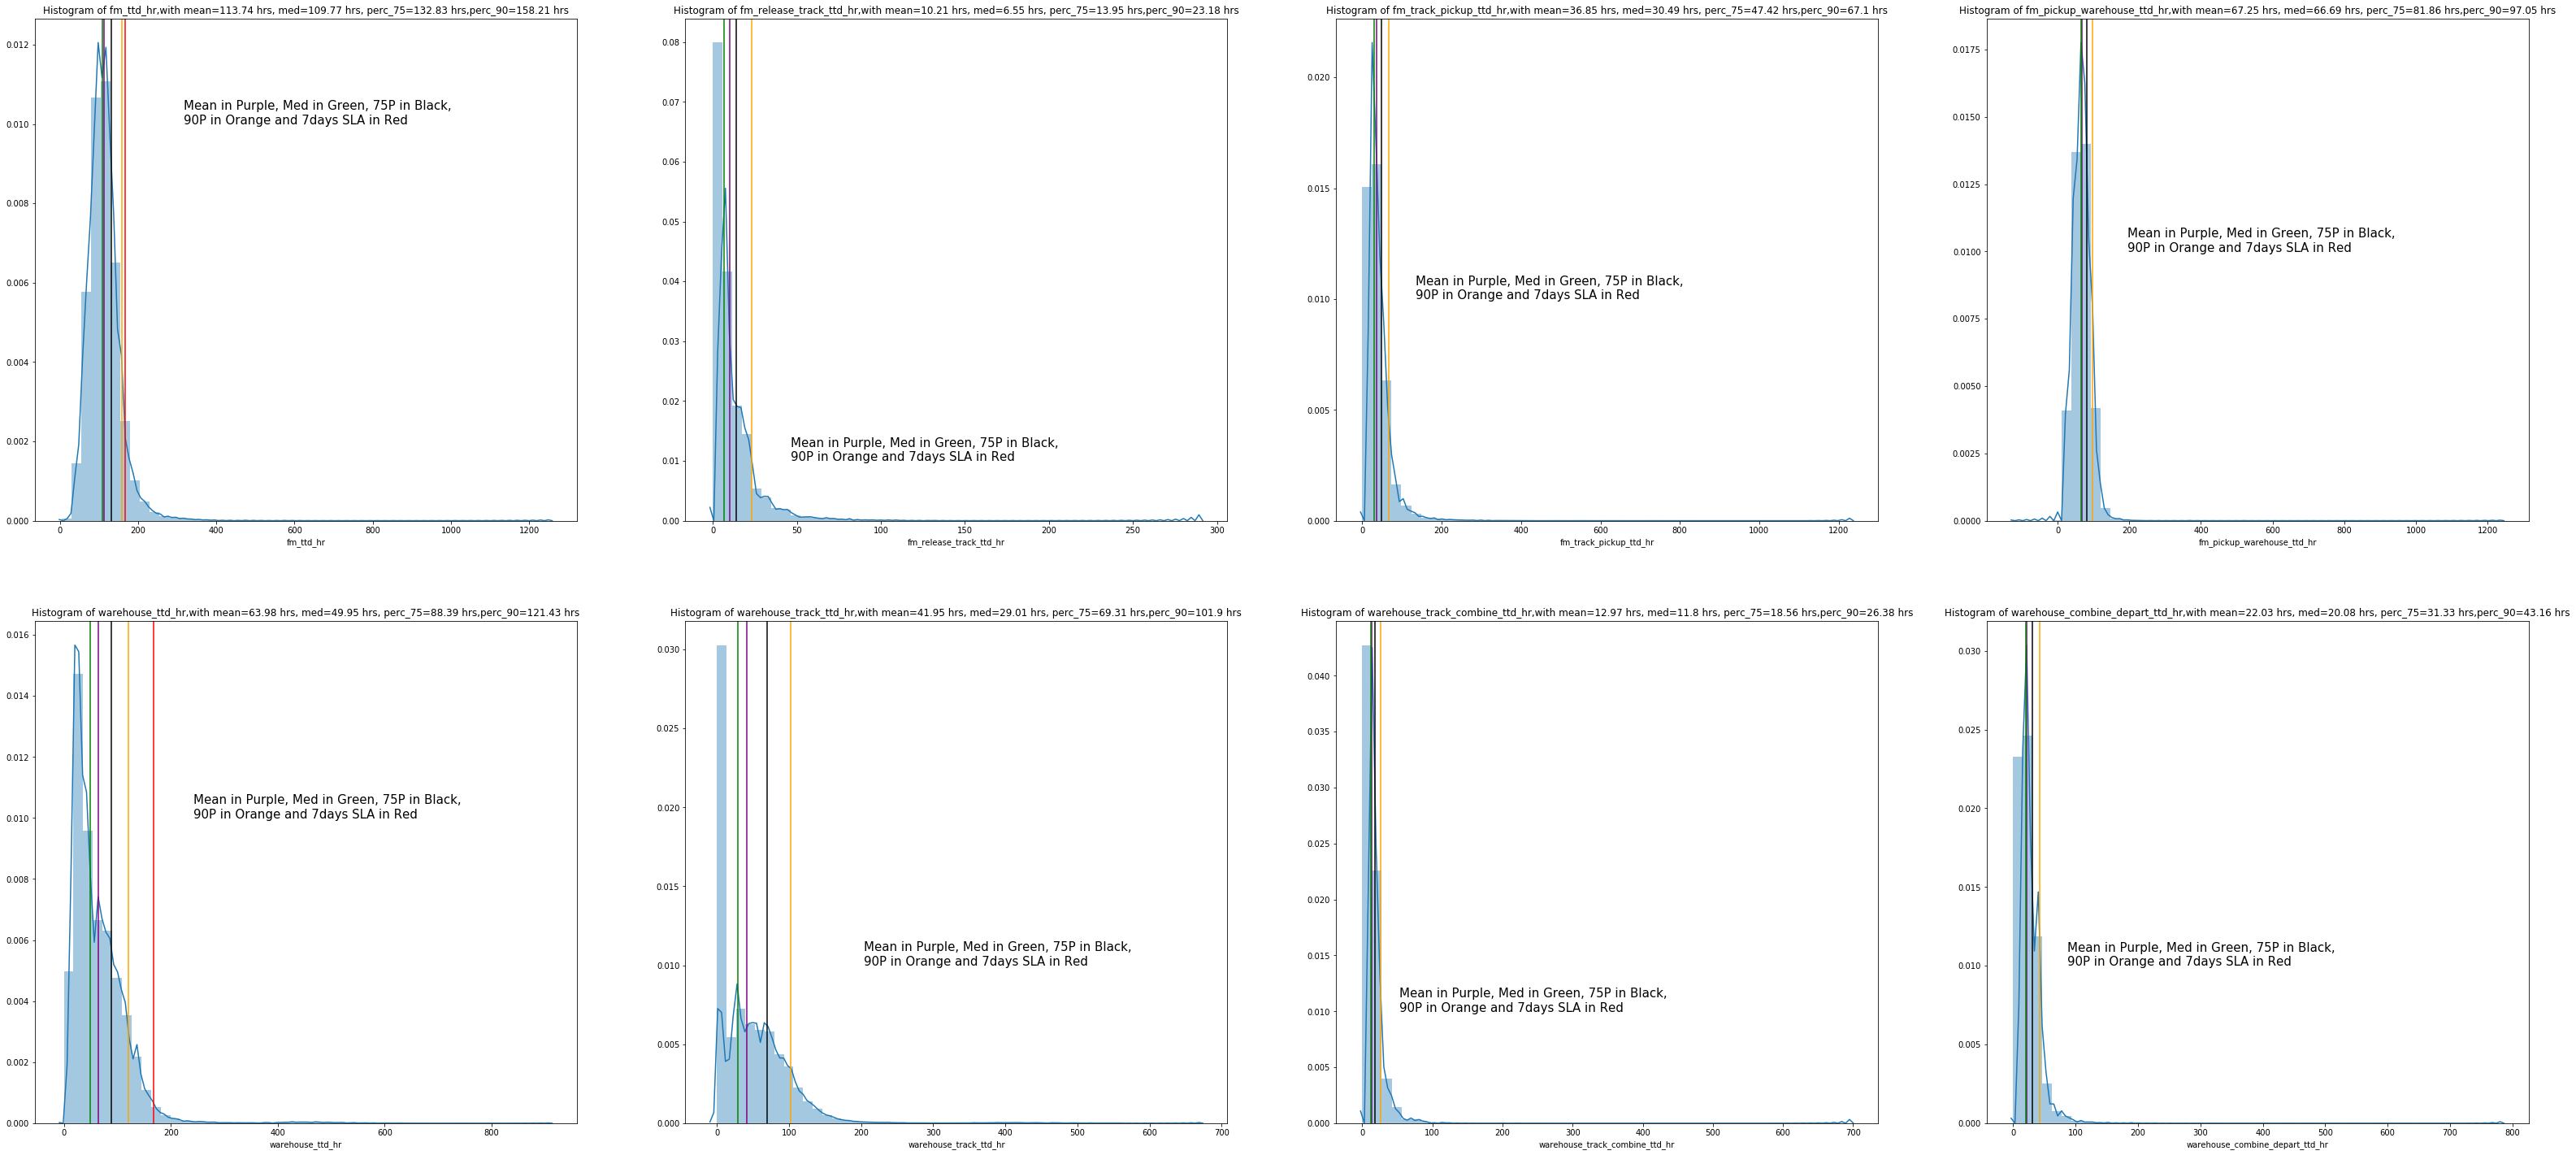

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Delivery program is EPC
----------------------------------------------------------------------------------------------------------------------------------------------------------------


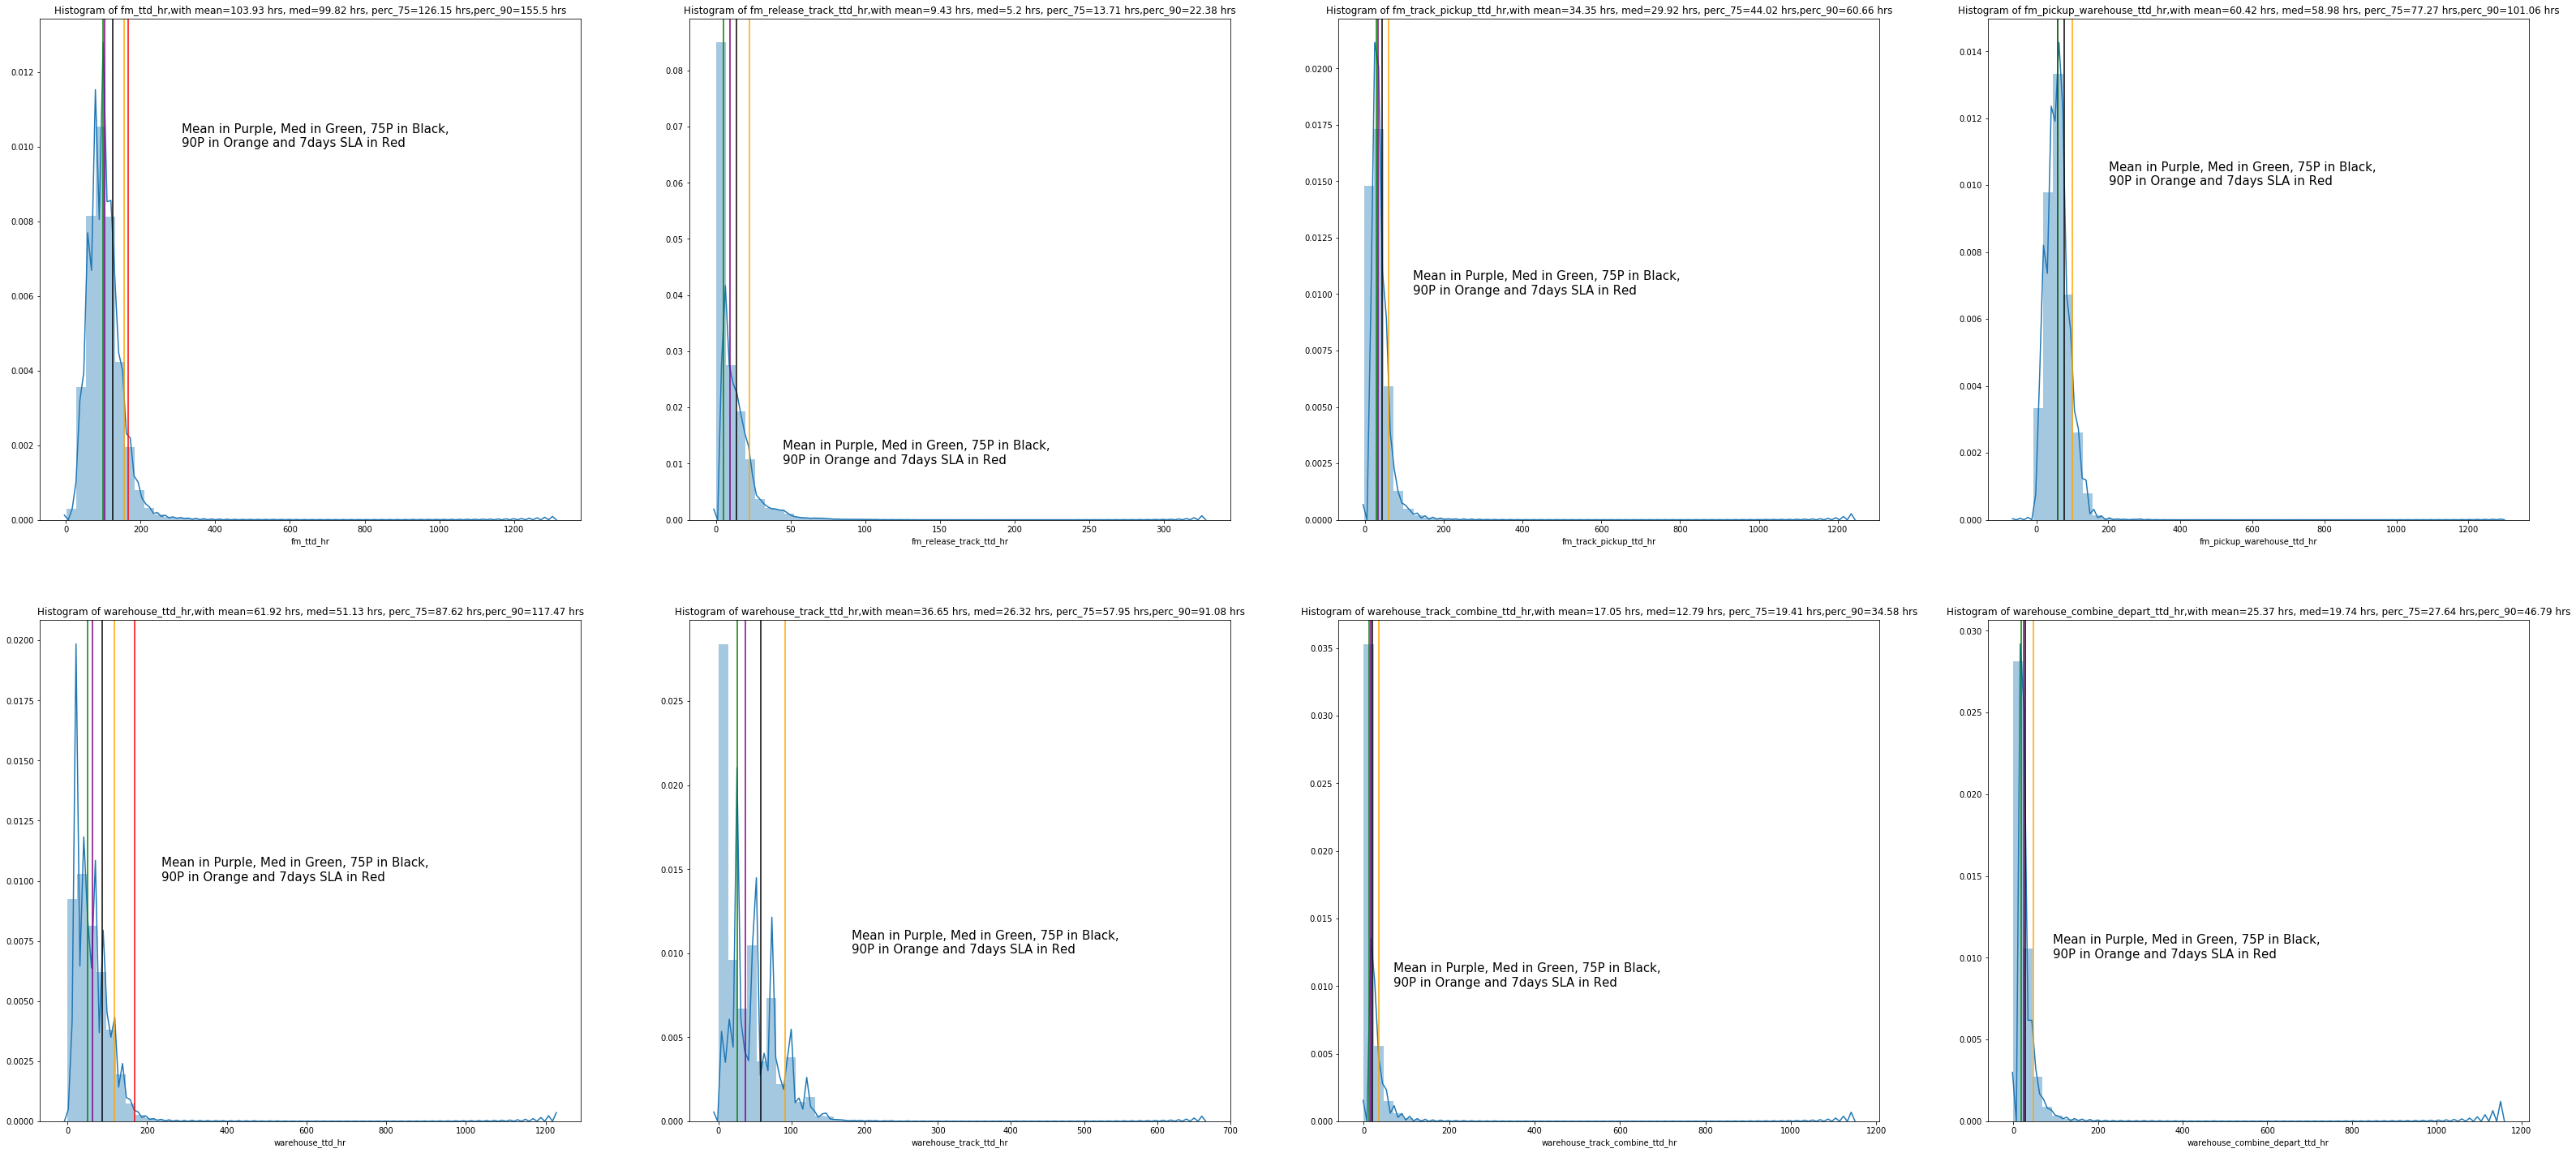

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Delivery program is Fusion
----------------------------------------------------------------------------------------------------------------------------------------------------------------


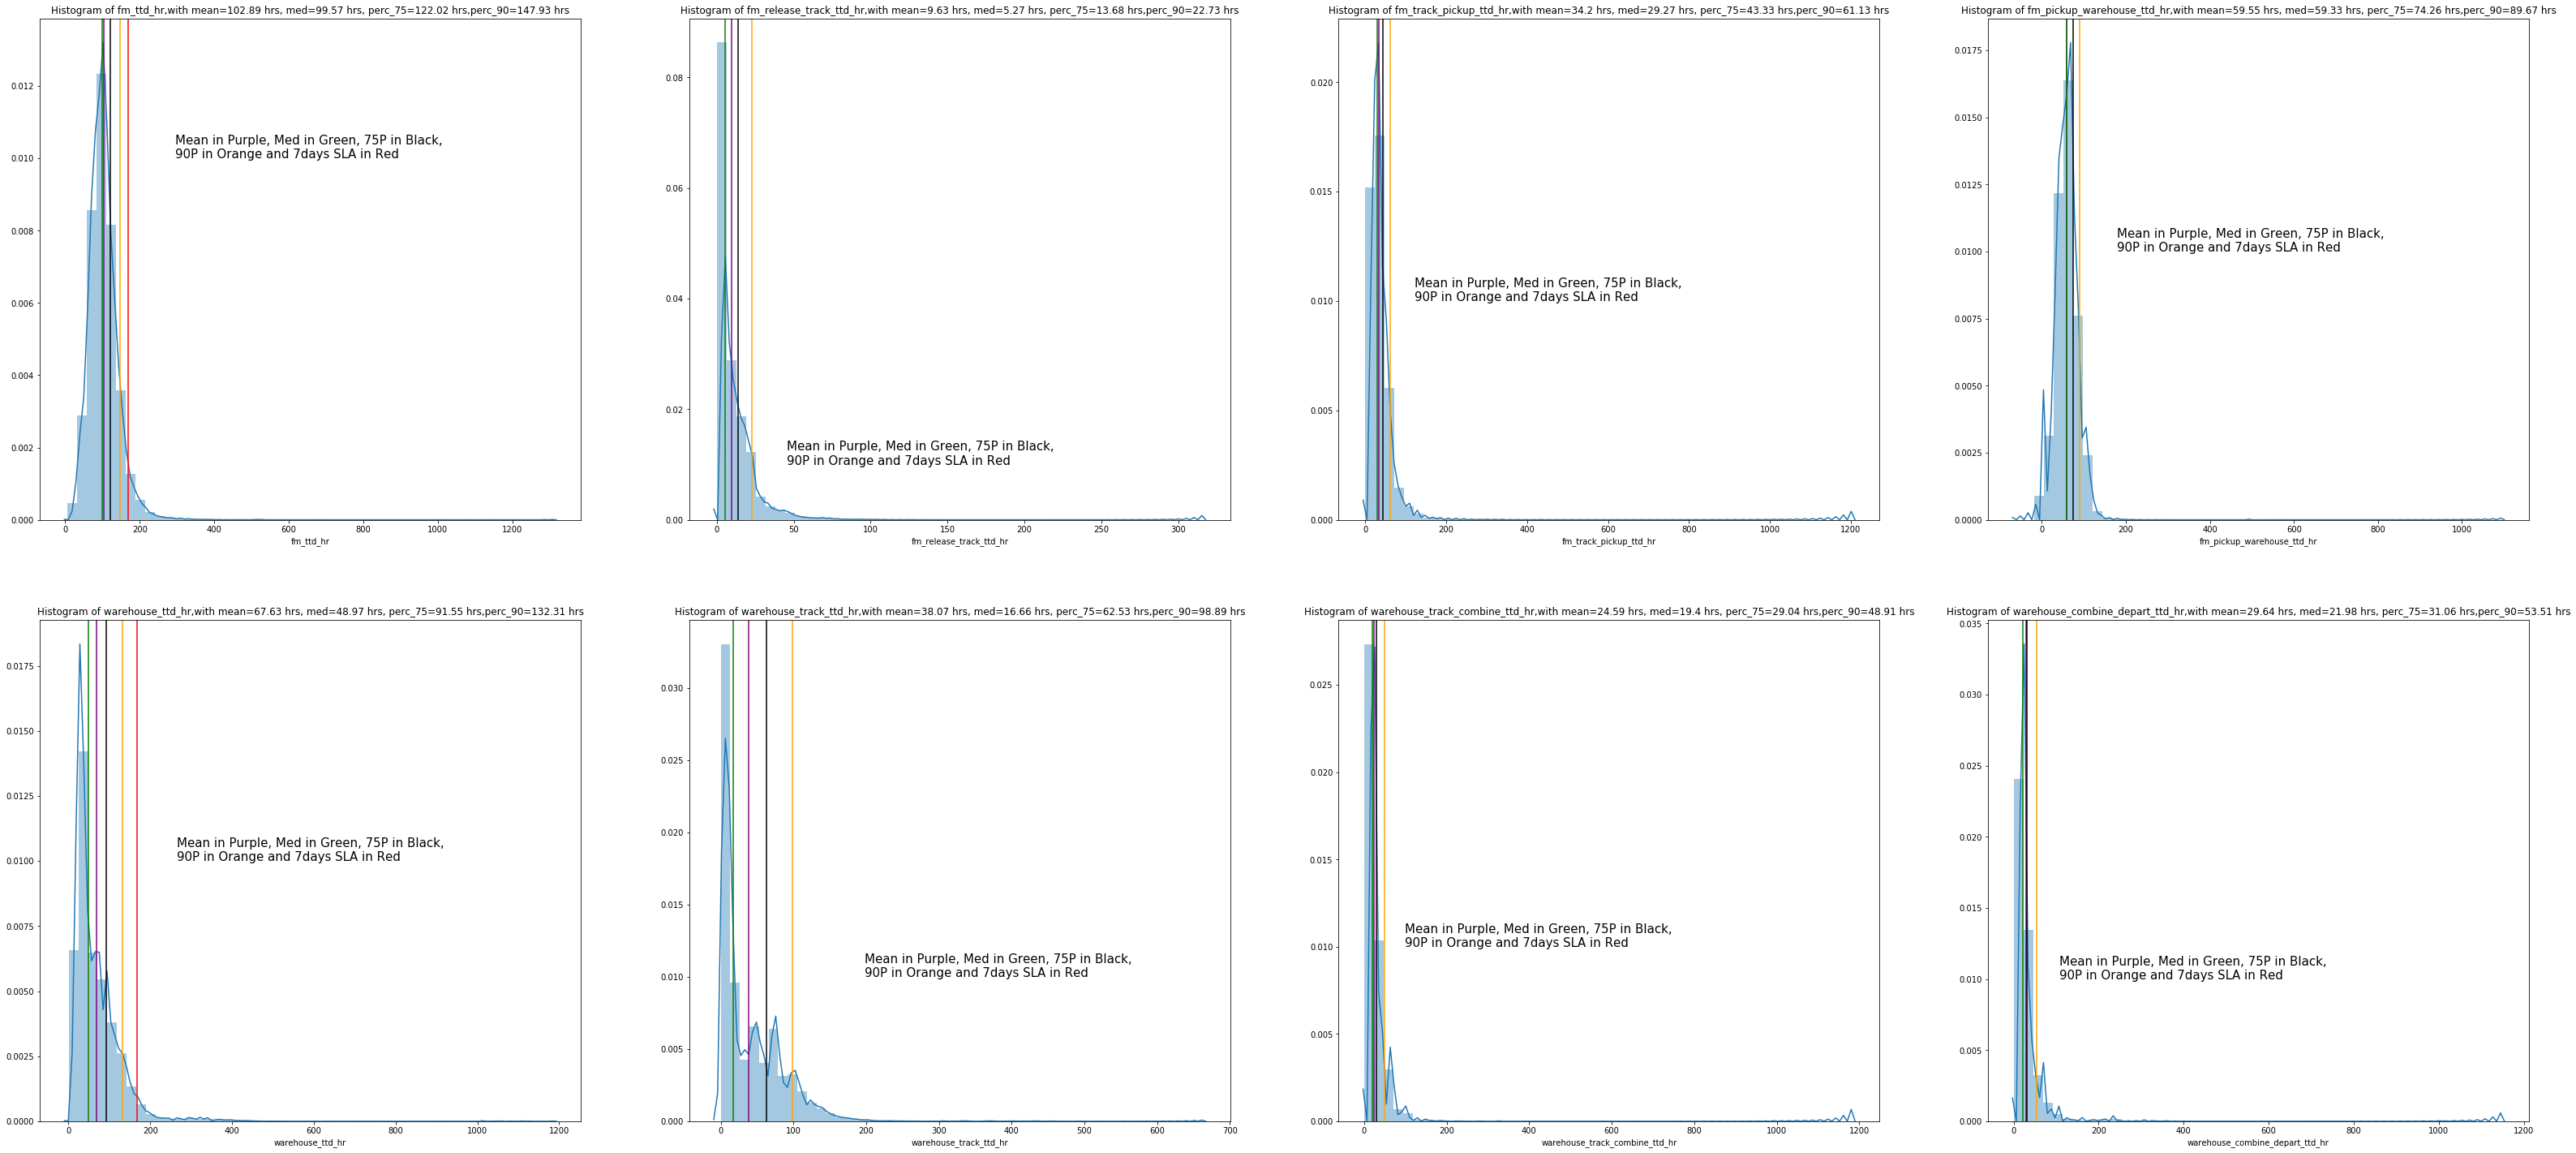

In [9]:

for delivery in delivery_list:
    print('-'*160)
    print('Delivery program is %s' %(delivery))
    print('-'*160)
    fig, axes = plt.subplots(2,4, figsize=(55,25))
    
    for i in range(l):
        m = int(i / 4)
        n = int(i % 4)
        
        mask1 = (df['delivery_program'] == delivery)
        mask2 = (df[checkpoint_list[i]].notnull())
        
        avg = round(df.loc[mask1 & mask2 , checkpoint_list[i]].mean(),2)
        perc_50 = round(df.loc[mask1 & mask2,checkpoint_list[i]].median(),2)
        perc_75= round(df.loc[mask1 & mask2,checkpoint_list[i]].quantile(0.75),2)
        perc_90= round(df.loc[mask1 & mask2,checkpoint_list[i]].quantile(0.9),2)
        
        sns.distplot(df.loc[mask1 & mask2,checkpoint_list[i]], hist=True, kde=True, bins=50, ax=axes[m, n])
        
        axes[m, n].title.set_text('Histogram of %s,with mean=%s hrs, med=%s hrs, perc_75=%s hrs,perc_90=%s hrs' %(checkpoint_list[i],avg,perc_50,perc_75,perc_90))
        axes[m, n].axvline(avg, 0, 1, color='purple')
        axes[m, n].axvline(perc_50, 0, 1, color='green')
        axes[m, n].axvline(perc_75, 0, 1,color='black')
        axes[m, n].axvline(perc_90, 0, 1, color='orange')
        if checkpoint_list[i] in ['fm_ttd_hr','warehouse_ttd_hr']:
            axes[m, n].axvline(7*24, 0, 1, color='red')
        axes[m, n].text(perc_90*2,0.010, 'Mean in Purple, Med in Green, 75P in Black, \n90P in Orange and 7days SLA in Red',size=15)
        
    plt.show()